# [Udacity Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) 
# Project 2: Continuous Control

This notebook contains Nishi Sood’s work for the Udacity's Deep Reinforcement Learning Nanodegree Project 2: Continuous Control. For this project, I have trained an agent that could control a double-jointed arm towards specific locations.

The aim is to train an agent that is capable of dealing with continuous valued inputs and outputs. 
Deep Deterministic Policy Gradient algorithm([https://arxiv.org/pdf/1509.02971.pdf] is used for Solutioning

## Project's goal
 - In this environment, a double-jointed arm can move to target locations. 
 - A reward of +0.1 is provided for each step that the agent's hand is in the goal location. 
 - The goal of the agent is to maintain its position at the target location for as many time steps as possible.
 - The environment solved in this project is a variant of the Reacher Environment agent by Unity.
 - The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector should be a number between -1 and 1.

## Environment Set Up

Note:: We assumes you have [NumPy](http://www.numpy.org/), [Matplotlib](https://matplotlib.org/), [Pytorch](https://pytorch.org/) and [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) installed. Please read the README.md file for instructions on how to install these prerequisites. 


In [1]:
#This imports the necessary packages. 
import numpy as np
import torch
import time
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from unityagents import UnityEnvironment
from ddpg_agent import MultiAgent

# Setting up the environment

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, for the headless Linux version, the code will look like:

```
env = UnityEnvironment(file_name="Reacher_Linux_NoVis/Reacher.x86_64")
```

In [2]:
#Loading the environment. To use please replace the value of the file_name with the location of the reacher environment.
env = UnityEnvironment(file_name='Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Unity environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## Explore the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

The following code cell prints out some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


# Create and Train the MultiAgent 

In [5]:
# Set environment to train mode
env_info = env.reset(train_mode=True)[brain_name]

# Create agent
agent = MultiAgent(state_size=state_size, action_size=action_size, n_agents=num_agents, seed=42)

In [6]:
# TRAIN SETTINGS
max_t = 1000        # max number of timesteps per episode
solved_score = 30.0 # Score that must be met to be considered solved
solved_window = 100 # number of episodes used to calculate mean to check if solution satisified
print_every = 10    # How often to keep a persistent version of printout

# HISTORY - keep track of progress
scores_deque = deque(maxlen=solved_window) # used to average over window of last scores
scores = []         # track all history of episode scores
best_average_score = -np.inf

Below is the code that will actually loop through many rounds of training an agent to interact with the environment. The loop stops once the agent has solved the problem. A snapshot of the agent is saved for each episode in which there is an improvement in performance.

In [7]:
# TRAIN LOOP

epochs = 1000 # number of training epochs
print("{sep}\nTRAINING\n{sep}".format(sep="="*60))
print("Using Device: ", agent.device)
t0 =  time.time()
for i_episode in range(1, epochs+1):
    # RESET ENVIRONMENT, STATE AND SCORES
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    episode_scores = np.zeros(num_agents) # score for each agent within episode
    agent.reset()

    # COLLECT AN EPISODE OF EXPERIENCE FROM EACH AGENT
    for t in range(max_t):
        # A single step of interaction with the environment for each agent
        actions = agent.act(states)
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done

        # Perform step of caching experience / training on experiences
        agent.step(states=states, actions=actions, rewards=rewards, next_states=next_states, dones=dones)

        # Sum up rewards separately for each agent
        episode_scores += np.array(rewards)

        # Prepare for next timestep of iteraction
        states = next_states  # new states become the current states

        # Check if any of the agents has finished. Finish to keep all
        # trajectories in this batch the same size.
        if np.any(dones):
            break

    # UPDATE SCORES
    episode_score = np.mean(episode_scores) # Summary of scores for this episode
    scores_deque.append(episode_score)
    average_score = np.mean(scores_deque)
    scores.append(episode_score)

    # FEEDBACK
    t1 = (time.time()-t0)/60. # time taken so far
    print('\rEpisode: {: 5d}\tTime (Mins): {:3.2f}\tAverage Score: {: 3.2f}\tCurrent Score: {: 3.2f}'.format(i_episode, t1, average_score, episode_score), end="")
    if i_episode % print_every == 0:
        print('\rEpisode: {: 5d}\tTime (Mins): {:3.2f}\tAverage Score: {: 3.2f}\tCurrent Score: {: 3.2f}'.format(i_episode, t1, average_score, episode_score))

    # SAVE SNAPSHOT - if it is better than previous models
    if (i_episode >= solved_window) and (average_score > best_average_score):
        best_average_score = average_score
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')

    # CHECK IF SOLVED
    if average_score >= solved_score:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-solved_window, average_score))
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        break


TRAINING
Using Device:  cpu
Episode:    10	Time (Mins): 6.99	Average Score:  0.77	Current Score:  1.06
Episode:    20	Time (Mins): 17.72	Average Score:  0.94	Current Score:  1.42
Episode:    30	Time (Mins): 33.85	Average Score:  1.19	Current Score:  1.93
Episode:    40	Time (Mins): 47.02	Average Score:  1.69	Current Score:  3.77
Episode:    50	Time (Mins): 62.20	Average Score:  2.37	Current Score:  5.68
Episode:    60	Time (Mins): 80.56	Average Score:  2.96	Current Score:  6.69
Episode:    70	Time (Mins): 117.36	Average Score:  3.65	Current Score:  9.29
Episode:    80	Time (Mins): 144.86	Average Score:  4.27	Current Score:  10.29
Episode:    90	Time (Mins): 171.98	Average Score:  4.90	Current Score:  12.08
Episode:   100	Time (Mins): 197.31	Average Score:  5.70	Current Score:  11.79
Episode:   110	Time (Mins): 221.63	Average Score:  7.03	Current Score:  15.07
Episode:   120	Time (Mins): 245.72	Average Score:  8.45	Current Score:  15.64
Episode:   130	Time (Mins): 269.20	Average Score: 

In [8]:
# CLOSE ENVIRONMENT
env.close()

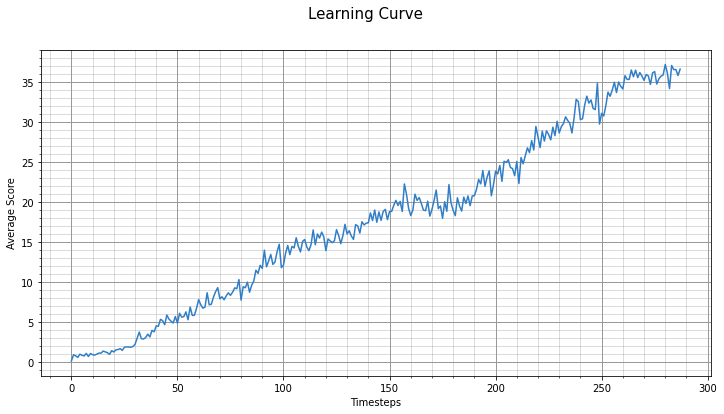

In [9]:
# ##############################################################################
# LEARNING CURVE
# ##############################################################################
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle("Learning Curve", fontsize=15)
ax.plot(scores, color="#307EC7", label="line")
ax.set_xlabel("Timesteps")
ax.set_ylabel("Average Score")
# GRID
ax.grid(True)
ax.grid(b=True, which='major', color='#999999', linestyle='-', linewidth=1)
ax.minorticks_on()
ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.7, linewidth=0.5)
fig.savefig("learning_curves.jpg")

# Ideas for future work

- We could have used different Optimization algorithm to check the difference in the Agent trained and its performance.
- There could be better results by making use of prioritized experience replay with the existing learning algorithm.
- Distributed Distributional Deterministic Policy Gradients (D4PG) has achieved state of the art results on continuous control problems. Also, PPO, A3C can be used in multi agent training environment.
- It would be interesting to see how the agent performs on this environment in future implementations.
- In future implementations,  I can try testing the agent with difference hyperparameter values, like different Sigma values, faster and smaller learning rates, tweaking the neural network, to choose the final model